# Image Denoising with UNet and Hyperparameter Tuning using Weights & Biases (WandB)

We aim to remove the noise from images in 'noisy35' dir, given that the original images are available.

Dataset used - https://github.com/clausmichele/CBSD68-dataset

Hyperparameter Tuning report - https://api.wandb.ai/links/krishnams0ni-manipal-university-jaipur/0k1fe20c

- Methodology:
  - Data Augmentation - Flipped dataset horizontally and vertically. So the dataset size went from 68 to 204.
  - Train-test split - 80:20
  - Created a (shallow) UNet model with 2 encoder and 2 decoder blocks and a small bottleneck due to computational constraints, although it performed relatively well.
  - Ran a sweep using Weights and Biases, in which I tried using various normalization techniques and loss functions to see how they influence performance.
- Hyperparameters:
  - Batch size - 4
  - Optimizer - adam
  - Epochs - 40
  - Loss - MAE, MSE
  - Norm layers - Instance, Group, Batch, Layer

| ID           | Loss        | Norm Layer         |       val_psnr |       val_ssim |       train_psnr |       train_ssim |
|--------------|-------------|--------------------|----------------|----------------|------------------|------------------|
| sctyz8o8     | mse         | layer              | 27.4126        | 0.7709         | 27.4236          | 0.7670          |
| **tc3ro0na** (best)     | mae         | layer              | 27.4977        | 0.7837         | 27.6701          | 0.7794          |
| zot7p3s5     | mse         | instance           | 23.2120        | 0.7113         | 23.9023          | 0.7211          |
| gsnhnk1p     | mae         | instance           | 22.3896        | 0.6954         | 22.8644          | 0.7113          |
| g9tfvtsp     | mse         | batch              | 23.5803        | 0.6961         | 23.5929          | 0.7184          |
| 6bmoex8d     | mae         | batch              | 15.2605        | 0.6663         | 23.6515          | 0.7281          |
| 2d0et6hj     | mse         | group              | 26.8831        | 0.7624         | 26.8922          | 0.7630          |
| t0g978j8     | mae         | group              | 26.4079        | 0.7716         | 26.5204          | 0.7701          |


Training graph for model with best loss and norm layer (ID - tc3ro0na). See report (link above) for all graphs.

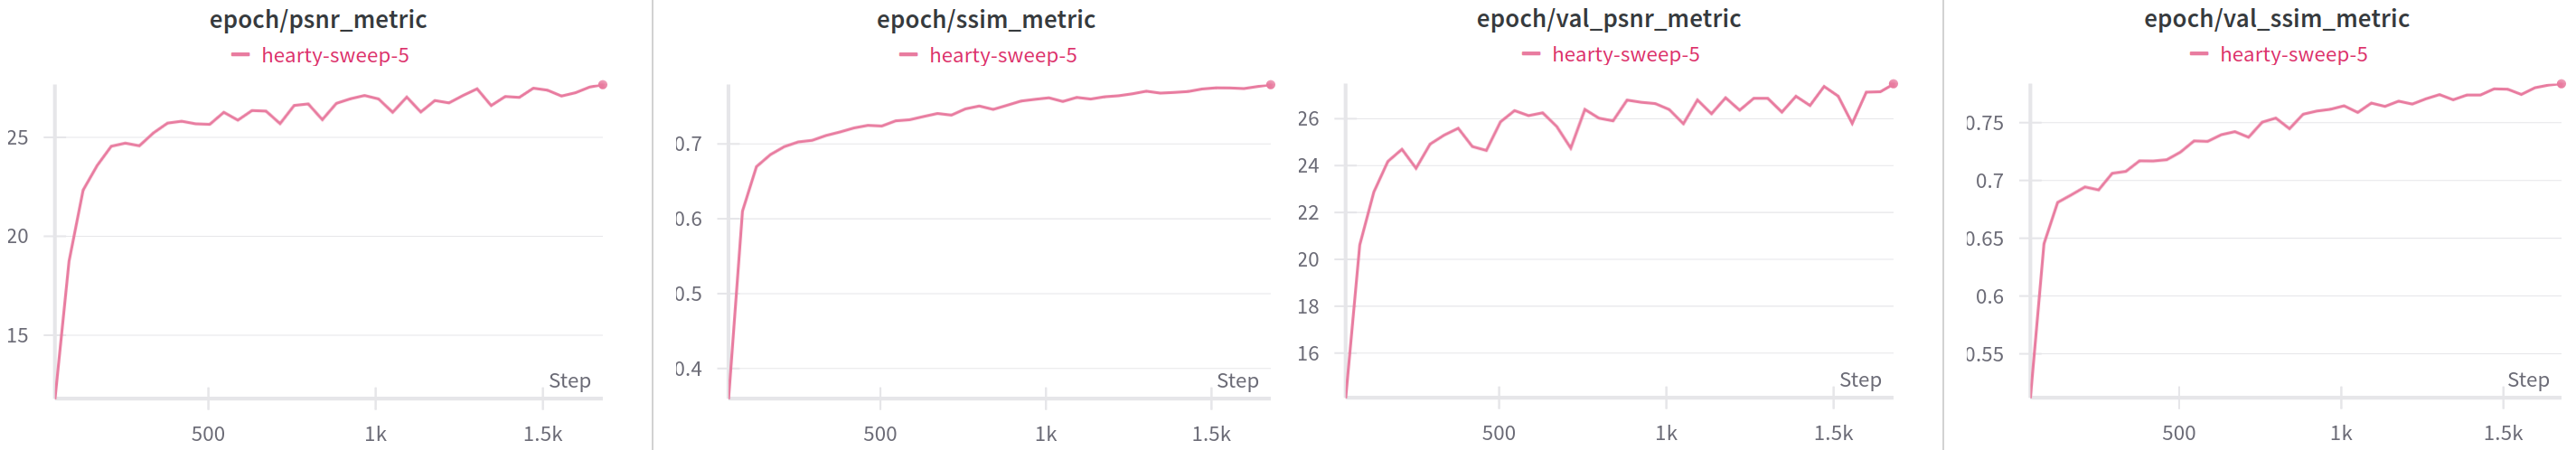

In [1]:
!git clone https://github.com/clausmichele/CBSD68-dataset.git

Cloning into 'CBSD68-dataset'...
remote: Enumerating objects: 564, done.
remote: Total 564 (delta 0), reused 0 (delta 0), pack-reused 564 (from 1)
Receiving objects: 100% (564/564), 181.30 MiB | 50.57 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import os
import time
import random
import gc
import re
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dropout, Conv2D, Input, MaxPool2D, UpSampling2D, Conv2DTranspose, Concatenate, Activation, ReLU, 
                                     GroupNormalization, LayerNormalization, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, Model
from PIL import Image
import PIL
import PIL.Image
import pathlib
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

In [3]:
def load_images_to_array(folder_path):
    image_list = []
    filenames = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png')):
            filenames.append(int(filename[:-4]))

    filenames.sort()

    for filename in filenames:
        img_path = os.path.join(folder_path, "0"*(4-len(str(filename))) + str(filename) + ".png")
        img = Image.open(img_path)
        img_array = np.array(img)
        if img_array.shape != (321, 481, 3):
            img_array = np.transpose(img_array, (1, 0, 2))[:, ::-1, :]
        img_array = img_array[1:, 1:]
        image_list.append(img_array)

    image_list = np.array(image_list)
    image_list = image_list.astype('float32') / 255.0
    return image_list

In [4]:
blurry_path = "CBSD68-dataset/CBSD68/noisy35"
blurry_images_dataset = load_images_to_array(blurry_path)

In [5]:
original_path = "CBSD68-dataset/CBSD68/original_png"
original_images_dataset = load_images_to_array(original_path)

In [6]:
blurry_images_dataset.shape, original_images_dataset.shape

((68, 320, 480, 3), (68, 320, 480, 3))

In [7]:
def augment_images(blurry, original, data_augmentation):
    combined = tf.concat([blurry, original], axis=-1)
    augmented = data_augmentation(combined)
    blurry_aug = augmented[..., :3]
    original_aug = augmented[..., 3:]
    return blurry_aug, original_aug

aug_blurry_list = []
aug_original_list = []

for _ in range(1):
    dataset = tf.data.Dataset.from_tensor_slices((blurry_images_dataset, original_images_dataset))
    
    for blurry, original in zip(blurry_images_dataset, original_images_dataset):
        blurry_aug, original_aug = augment_images(blurry, original, tf.image.flip_left_right)
        aug_blurry_list.append(blurry_aug.numpy())
        aug_original_list.append(original_aug.numpy())
        
        blurry_aug, original_aug = augment_images(blurry, original, tf.image.random_flip_up_down)
        aug_blurry_list.append(blurry_aug.numpy())
        aug_original_list.append(original_aug.numpy())
        
aug_blurry_np = np.array(aug_blurry_list)
aug_original_np = np.array(aug_original_list)

aug_blurry_np.shape, aug_original_np.shape

((136, 320, 480, 3), (136, 320, 480, 3))

In [8]:
blurry_images = np.concatenate([aug_blurry_np, blurry_images_dataset], axis=0)
original_images = np.concatenate([aug_original_np, original_images_dataset], axis=0)
blurry_images.shape, original_images.shape

((204, 320, 480, 3), (204, 320, 480, 3))

In [9]:
SEED = 3
def set_random_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_random_seed()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(blurry_images, original_images, test_size=0.2, random_state=SEED)

In [11]:
def get_model_unet(input_shape=(320, 480, 3),
                   conv_filt=64,
                   kernel_size=3,
                   activation="relu",
                   padding="same",
                   pool_size=2,
                   norm_layer="layer"):
    conv_args = {
        "kernel_size": kernel_size,
        "activation": activation,
        "padding": padding,
    }

    inputs = Input(shape=input_shape)

    def apply_norm(x):
        if norm_layer == "layer":
            return LayerNormalization()(x)
        if norm_layer == "group":
            return GroupNormalization(groups=16)(x)
        if norm_layer == "instance":
            return GroupNormalization(groups=-1)(x) # see https://keras.io/api/layers/normalization_layers/group_normalization/
        return BatchNormalization()(x)

    x = Conv2D(conv_filt, **conv_args)(inputs)
    x = apply_norm(x)
    x = Conv2D(conv_filt, **conv_args)(x)
    x = apply_norm(x)
    skip1 = x
    x = MaxPool2D(pool_size)(x)

    x = Conv2D(conv_filt * 2, **conv_args)(x)
    x = apply_norm(x)
    x = Conv2D(conv_filt * 4, **conv_args)(x)
    x = apply_norm(x)
    skip2 = x
    x = MaxPool2D(pool_size)(x)

    x = Conv2D(conv_filt * 2, **conv_args)(x)
    x = apply_norm(x)
    x = Conv2D(conv_filt * 4, **conv_args)(x)
    x = apply_norm(x)
    
    x = UpSampling2D(size=pool_size)(x)
    x = Concatenate()([skip2, x])
    x = Conv2D(conv_filt * 2, **conv_args)(x)
    x = apply_norm(x)
    x = Conv2D(conv_filt * 2, **conv_args)(x)
    x = apply_norm(x)

    x = UpSampling2D(size=pool_size)(x)
    x = Concatenate()([skip1, x])
    x = Conv2D(conv_filt, **conv_args)(x)
    x = apply_norm(x)
    x = Conv2D(conv_filt, **conv_args)(x)
    x = apply_norm(x)

    outputs = Conv2D(3, kernel_size=1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
!wandb login KEY_HIDDEN

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'ssim',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [4]},
        'epoch': {'values': [40]},
        'loss': {'values': ['mse', 'mae']},
        'optimizer': {'values': ['adam']},
        'norm_layer': {'values': ['layer', 'instance', 'group', 'batch']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="denoising_using_unet")
# sweep_id = "d8jmlq4e"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: d8jmlq4e
Sweep URL: https://wandb.ai/krishnams0ni-manipal-university-jaipur/denoising_using_unet/sweeps/d8jmlq4e


In [14]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [15]:
l = []

def train():
    wandb.init()
    config = wandb.config
    
    model = get_model_unet(norm_layer=config.norm_layer)
    model.compile(
        optimizer=config.optimizer,
        loss=config.loss,
        metrics=[psnr_metric, ssim_metric]
    )

    model.fit(
        x=X_train, y=y_train,
        epochs=config.epoch,
        batch_size=config.batch_size,
        validation_data=(X_test, y_test),
        callbacks=[WandbMetricsLogger(log_freq=1)]
    )

    final_val_psnr = wandb.run.summary.get('epoch/val_psnr_metric')
    final_val_ssim = wandb.run.summary.get('epoch/val_ssim_metric')
    final_train_psnr = wandb.run.summary.get('epoch/psnr_metric')
    final_train_ssim = wandb.run.summary.get('epoch/ssim_metric')

    model.save(f"model-{wandb.run.id}.h5")
    metrics = [wandb.run.id, config.loss, config.norm_layer, final_val_psnr, final_val_ssim, final_train_psnr, final_train_ssim]
    print(metrics)
    l.append(metrics)
    
    wandb.finish()

wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: sctyz8o8 with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mse
wandb: 	norm_layer: layer
wandb: 	optimizer: adam
wandb: Currently logged in as: krishnams0ni (krishnams0ni-manipal-university-jaipur). Use `wandb login --relogin` to force relogin


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 960ms/step - loss: 0.0812 - psnr_metric: 11.6603 - ssim_metric: 0.2903 - val_loss: 0.0196 - val_psnr_metric: 17.2741 - val_ssim_metric: 0.5687
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0175 - psnr_metric: 18.3507 - ssim_metric: 0.5844 - val_loss: 0.0070 - val_psnr_metric: 21.9027 - val_ssim_metric: 0.6258
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0062 - psnr_metric: 22.4426 - ssim_metric: 0.6416 - val_loss: 0.0048 - val_psnr_metric: 23.5867 - val_ssim_metric: 0.6643
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0042 - psnr_metric: 24.0625 - ssim_metric: 0.6700 - val_loss: 0.0039 - val_psnr_metric: 24.3739 - val_ssim_metric: 0.6773
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0037 - psnr_metric: 24.6901 - ssim_metric: 0.6810 - val_loss: 0.0033 - val_psnr_metric: 25.1101 - val_ssim_metric: 0.6856
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0031 - psnr_metri

wandb: Agent Starting Run: zot7p3s5 with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mse
wandb: 	norm_layer: instance
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 506ms/step - loss: 0.0479 - psnr_metric: 14.3498 - ssim_metric: 0.3404 - val_loss: 0.0184 - val_psnr_metric: 18.2141 - val_ssim_metric: 0.5934
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0203 - psnr_metric: 17.6175 - ssim_metric: 0.5757 - val_loss: 0.0161 - val_psnr_metric: 18.9044 - val_ssim_metric: 0.6190
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0168 - psnr_metric: 18.5235 - ssim_metric: 0.6021 - val_loss: 0.0152 - val_psnr_metric: 19.1601 - val_ssim_metric: 0.6276
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0148 - psnr_metric: 19.1548 - ssim_metric: 0.6142 - val_loss: 0.0151 - val_psnr_metric: 19.0666 - val_ssim_metric: 0.6287
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0140 - psnr_metric: 19.3607 - ssim_metric: 0.6198 - val_loss: 0.0138 - val_psnr_metric: 19.4090 - val_ssim_metric: 0.6211
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0128 - psnr_metri

wandb: Agent Starting Run: 2d0et6hj with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mse
wandb: 	norm_layer: group
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 539ms/step - loss: 0.0484 - psnr_metric: 14.6011 - ssim_metric: 0.3777 - val_loss: 0.0165 - val_psnr_metric: 18.2660 - val_ssim_metric: 0.6089
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0137 - psnr_metric: 19.3393 - ssim_metric: 0.6101 - val_loss: 0.0098 - val_psnr_metric: 20.7810 - val_ssim_metric: 0.6568
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0102 - psnr_metric: 20.6994 - ssim_metric: 0.6410 - val_loss: 0.0083 - val_psnr_metric: 21.2965 - val_ssim_metric: 0.6647
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0071 - psnr_metric: 22.0142 - ssim_metric: 0.6593 - val_loss: 0.0081 - val_psnr_metric: 21.4829 - val_ssim_metric: 0.6801
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0074 - psnr_metric: 21.8544 - ssim_metric: 0.6735 - val_loss: 0.0063 - val_psnr_metric: 22.4373 - val_ssim_metric: 0.6643
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0055 - psnr_metri

wandb: Agent Starting Run: g9tfvtsp with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mse
wandb: 	norm_layer: batch
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 410ms/step - loss: 0.0361 - psnr_metric: 16.1068 - ssim_metric: 0.4020 - val_loss: 0.0388 - val_psnr_metric: 14.4323 - val_ssim_metric: 0.4934
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0113 - psnr_metric: 20.0048 - ssim_metric: 0.6477 - val_loss: 0.0401 - val_psnr_metric: 14.5533 - val_ssim_metric: 0.4845
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0097 - psnr_metric: 20.7284 - ssim_metric: 0.6647 - val_loss: 0.0400 - val_psnr_metric: 14.5795 - val_ssim_metric: 0.4772
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0093 - psnr_metric: 20.8229 - ssim_metric: 0.6665 - val_loss: 0.0392 - val_psnr_metric: 14.4921 - val_ssim_metric: 0.4940
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0085 - psnr_metric: 21.2678 - ssim_metric: 0.6757 - val_loss: 0.0337 - val_psnr_metric: 15.2244 - val_ssim_metric: 0.5025
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0077 - psnr_metri

wandb: Agent Starting Run: tc3ro0na with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mae
wandb: 	norm_layer: layer
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 452ms/step - loss: 0.2677 - psnr_metric: 10.1608 - ssim_metric: 0.2825 - val_loss: 0.1642 - val_psnr_metric: 14.0953 - val_ssim_metric: 0.5120
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.1119 - psnr_metric: 17.3745 - ssim_metric: 0.5750 - val_loss: 0.0755 - val_psnr_metric: 20.6314 - val_ssim_metric: 0.6456
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0651 - psnr_metric: 21.7793 - ssim_metric: 0.6578 - val_loss: 0.0568 - val_psnr_metric: 22.8831 - val_ssim_metric: 0.6812
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0539 - psnr_metric: 23.2933 - ssim_metric: 0.6819 - val_loss: 0.0483 - val_psnr_metric: 24.1874 - val_ssim_metric: 0.6877
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0462 - psnr_metric: 24.5521 - ssim_metric: 0.6931 - val_loss: 0.0457 - val_psnr_metric: 24.7026 - val_ssim_metric: 0.6945
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - loss: 0.0434 - psnr_metri

wandb: Agent Starting Run: gsnhnk1p with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mae
wandb: 	norm_layer: instance
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - loss: 0.1650 - psnr_metric: 14.2024 - ssim_metric: 0.3331 - val_loss: 0.1127 - val_psnr_metric: 17.2699 - val_ssim_metric: 0.5727
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.1146 - psnr_metric: 17.1226 - ssim_metric: 0.5604 - val_loss: 0.1027 - val_psnr_metric: 18.1239 - val_ssim_metric: 0.5814
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.1080 - psnr_metric: 17.7563 - ssim_metric: 0.5856 - val_loss: 0.1012 - val_psnr_metric: 18.3943 - val_ssim_metric: 0.5903
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.1021 - psnr_metric: 18.3698 - ssim_metric: 0.5946 - val_loss: 0.0943 - val_psnr_metric: 19.0394 - val_ssim_metric: 0.6076
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0964 - psnr_metric: 18.8134 - ssim_metric: 0.6090 - val_loss: 0.0929 - val_psnr_metric: 19.0238 - val_ssim_metric: 0.6082
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0958 - psnr_metri

wandb: Agent Starting Run: t0g978j8 with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mae
wandb: 	norm_layer: group
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 521ms/step - loss: 0.1489 - psnr_metric: 15.3849 - ssim_metric: 0.4293 - val_loss: 0.0967 - val_psnr_metric: 18.6702 - val_ssim_metric: 0.6192
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0905 - psnr_metric: 19.2046 - ssim_metric: 0.6225 - val_loss: 0.0915 - val_psnr_metric: 18.9692 - val_ssim_metric: 0.6538
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.0868 - psnr_metric: 19.6359 - ssim_metric: 0.6483 - val_loss: 0.1012 - val_psnr_metric: 18.2835 - val_ssim_metric: 0.6603
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0890 - psnr_metric: 19.4082 - ssim_metric: 0.6485 - val_loss: 0.0683 - val_psnr_metric: 21.4482 - val_ssim_metric: 0.6798
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0661 - psnr_metric: 21.5825 - ssim_metric: 0.6756 - val_loss: 0.0623 - val_psnr_metric: 22.1869 - val_ssim_metric: 0.6940
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0608 - psnr_metri

wandb: Agent Starting Run: 6bmoex8d with config:
wandb: 	batch_size: 4
wandb: 	epoch: 40
wandb: 	loss: mae
wandb: 	norm_layer: batch
wandb: 	optimizer: adam


Epoch 1/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 409ms/step - loss: 0.1402 - psnr_metric: 15.9575 - ssim_metric: 0.3917 - val_loss: 0.2593 - val_psnr_metric: 10.5550 - val_ssim_metric: 0.4220
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0824 - psnr_metric: 19.7422 - ssim_metric: 0.6451 - val_loss: 0.2122 - val_psnr_metric: 12.0369 - val_ssim_metric: 0.4395
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0773 - psnr_metric: 20.3601 - ssim_metric: 0.6644 - val_loss: 0.1883 - val_psnr_metric: 13.0825 - val_ssim_metric: 0.4547
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0739 - psnr_metric: 20.7477 - ssim_metric: 0.6746 - val_loss: 0.1751 - val_psnr_metric: 13.7701 - val_ssim_metric: 0.4803
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0721 - psnr_metric: 20.9851 - ssim_metric: 0.6828 - val_loss: 0.1565 - val_psnr_metric: 14.8432 - val_ssim_metric: 0.5134
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 0.0707 - psnr_metri

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [16]:
for _ in l: print(_)

['sctyz8o8', 'mse', 'layer', 27.412609100341797, 0.7709179520606995, 27.423627853393555, 0.7670298218727112]
['zot7p3s5', 'mse', 'instance', 23.211977005004883, 0.7112905979156494, 23.902278900146484, 0.721066951751709]
['2d0et6hj', 'mse', 'group', 26.883087158203125, 0.7624363303184509, 26.892248153686523, 0.7630409002304077]
['g9tfvtsp', 'mse', 'batch', 23.580257415771484, 0.6960690021514893, 23.592926025390625, 0.7184393405914307]
['tc3ro0na', 'mae', 'layer', 27.49765396118164, 0.7837330102920532, 27.67005729675293, 0.7793622612953186]
['gsnhnk1p', 'mae', 'instance', 22.389577865600586, 0.6953590512275696, 22.864368438720703, 0.7113481163978577]
['t0g978j8', 'mae', 'group', 26.407926559448242, 0.7715525031089783, 26.520370483398438, 0.770080029964447]
['6bmoex8d', 'mae', 'batch', 15.260462760925293, 0.6663342714309692, 23.651531219482422, 0.7281389832496643]


In [17]:
best_model = max(l, key=lambda x: 0.8*x[-1] + 0.2*x[-3])[0]
best_model

'tc3ro0na'

In [18]:
custom_objects = {
    'mse': keras.losses.MeanSquaredError(),
    'mae': keras.losses.MeanAbsoluteError(),
    'accuracy': keras.metrics.Accuracy()
}

model_path = f"model-{best_model}.h5"
model = keras.models.load_model(model_path, custom_objects=custom_objects)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


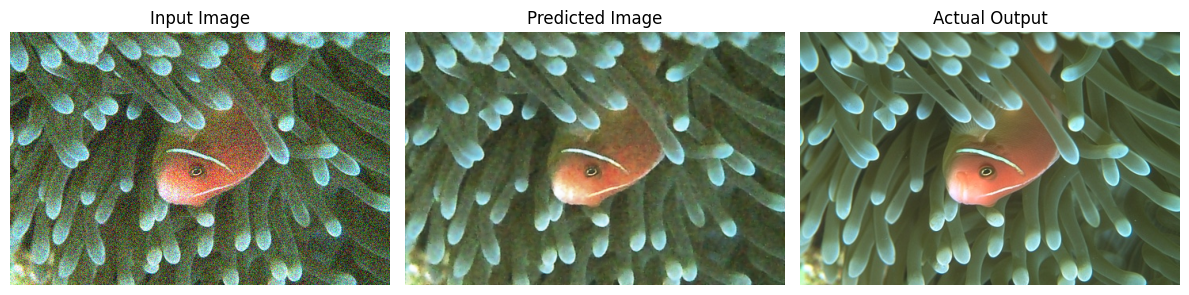

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


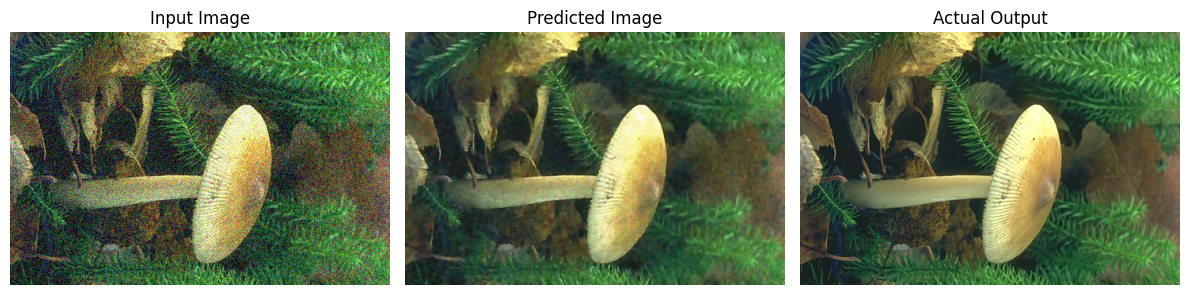

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


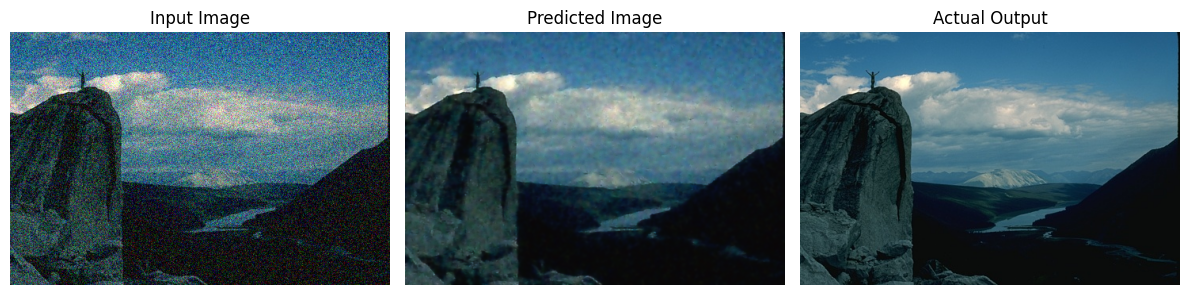

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


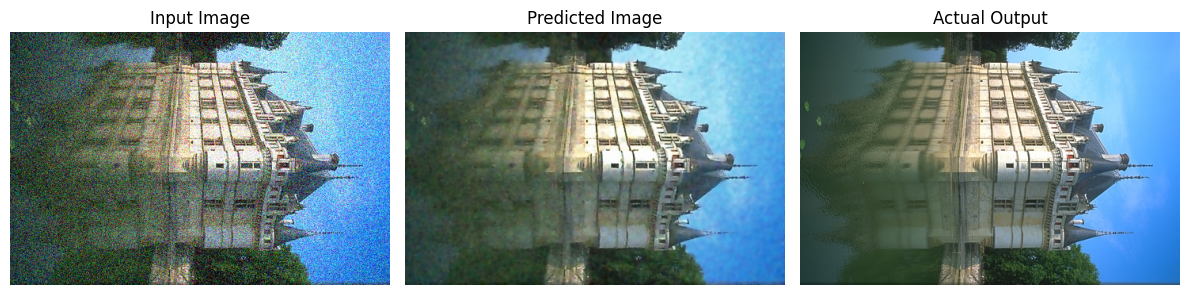

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


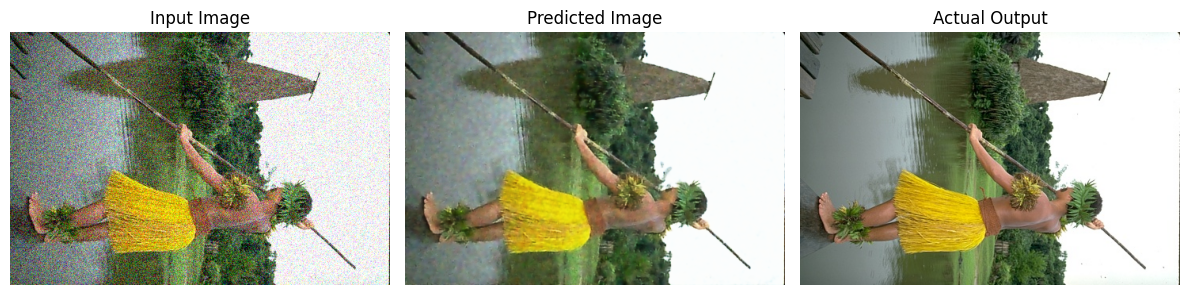

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


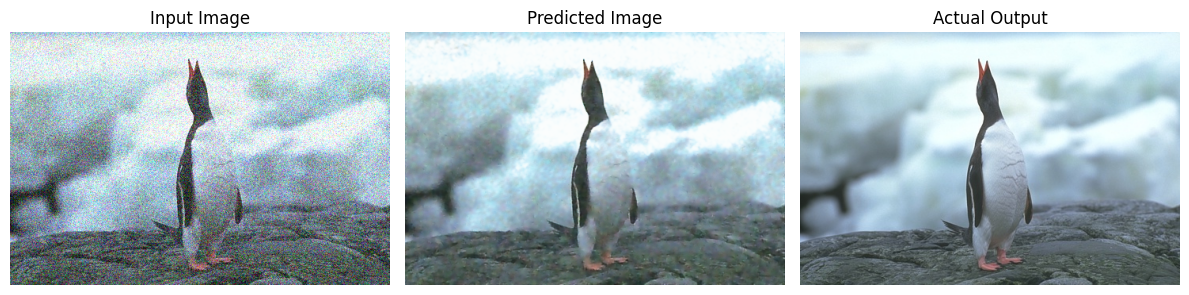

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


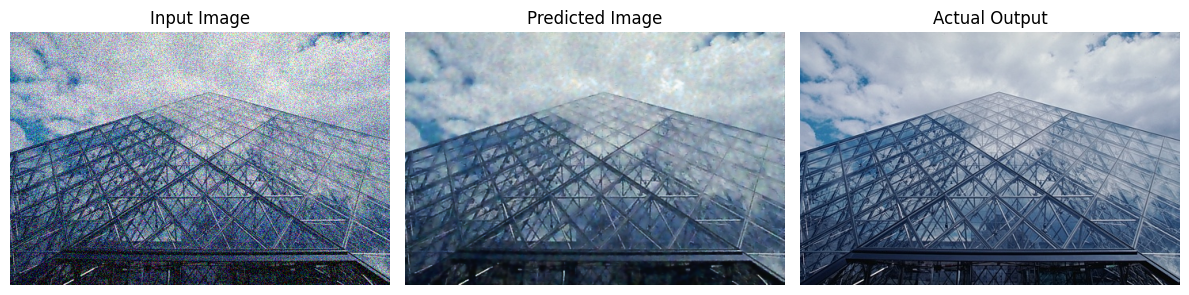

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


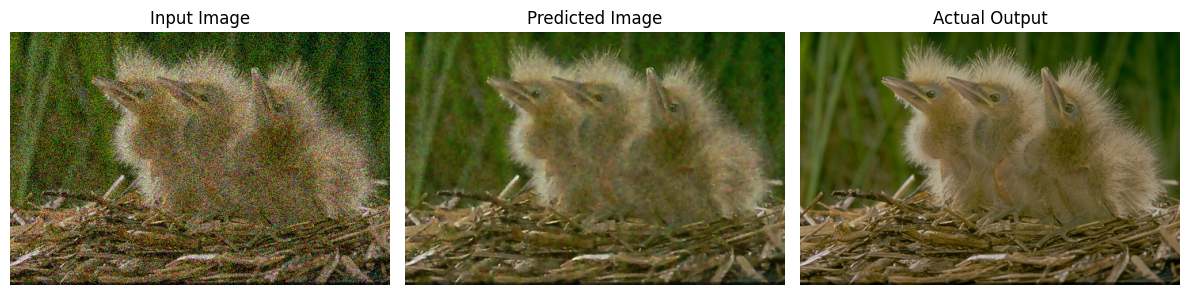

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


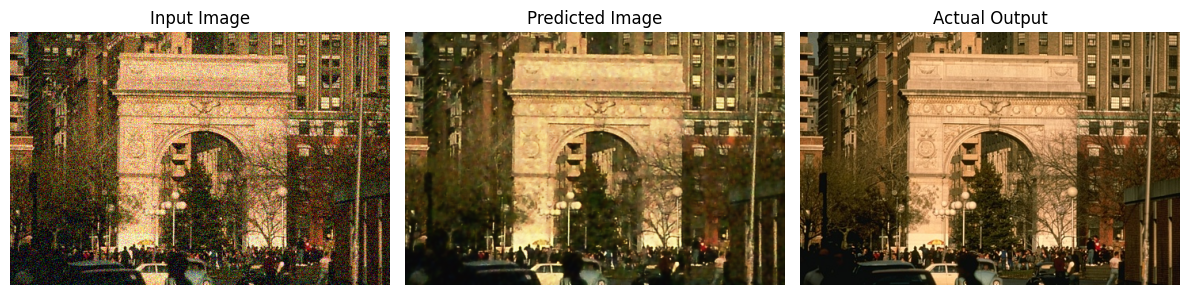

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


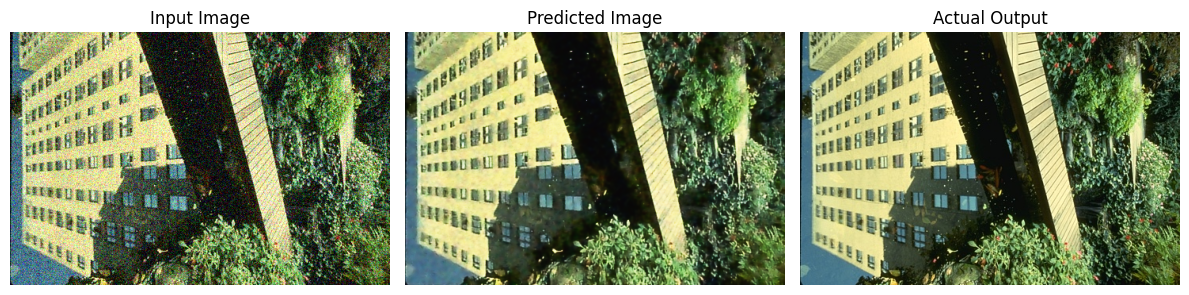

In [20]:
def show_image(index):
    input_img = blurry_images[index]
    output_img = original_images[index]
    predicted_img = model.predict(np.expand_dims(input_img, axis=0))[0]

    vmin = 0.0
    vmax = 1.0

    plt.figure(figsize=(12, 6))

    plt.subplot(131)
    plt.imshow(input_img, vmin=vmin, vmax=vmax)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(predicted_img, vmin=vmin, vmax=vmax)
    plt.title("Predicted Image")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(output_img, vmin=vmin, vmax=vmax)
    plt.title("Actual Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for _ in range(10):
    show_image(random.randint(0, len(blurry_images) - 1))